In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch.nn as nn
import torch.optim as optim
import math

# Load the dataset
df = pd.read_csv('DataSets/COVID-19_w_Polsce-Wzrost.csv', sep=';', usecols=['Data', 'Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia'])
df = df.dropna()

# Convert date strings to datetime objects
def convert_to_datetime_with_year_increment(date_series, start_year):
    previous_month = 0
    current_year = start_year
    datetime_list = []

    for date in date_series:
        current_month = int(date.split('/')[1])
        if current_month == 1 and previous_month == 12:
            current_year += 1
        date_with_year_str = date + f'/{current_year}'
        datetime_obj = datetime.strptime(date_with_year_str, '%d/%m/%Y')
        datetime_list.append(datetime_obj)

        previous_month = current_month

    return datetime_list

# Dla predykcji liczby nowych przypadków COVID-19, najważniejsze zmienne mogą obejmować:

# Zmiana liczby aktywnych przypadków: Może być wskaźnikiem trendu w liczbie nowych przypadków.
# Zmiana liczby nieaktywnych przypadków: Może wskazywać na przejście przypadków z aktywnych do wyzdrowiałych lub zmarłych.
# Nowe zgony: Mogą być powiązane z ciężkością sytuacji i liczbą nowych przypadków.
# Nowe wyzdrowienia: Może wpływać na liczbę aktywnych przypadków i potencjalnie na liczbę nowych przypadków.
# Liczba aktywnych przypadków: Obecna liczba aktywnych przypadków może wpływać na przyszłą liczbę nowych przypadków, sugerując wzrost lub spadek trendu.

df['Nowe przypadki'] = df['Nowe przypadki'].str.replace(' ', '').astype(int)
df['Zmiana liczby aktywnych przypadków'] = df['Zmiana liczby aktywnych przypadków'].str.replace(' ', '').astype(int)
df['Zmiana liczby nieaktywnych przypadków'] = df['Zmiana liczby nieaktywnych przypadków'].str.replace('( |-)', '', regex=True).astype(int)
df['Nowe zgony'] = df['Nowe zgony'].str.replace(' ', '').astype(int)
df['Nowe wyzdrowienia'] = df['Nowe wyzdrowienia'].str.replace('( |-)', '', regex=True).astype(int)

df['Data'] = df['Data'].apply(lambda x: "{:04.2f}".format(x).replace('.', '/'))
df['Data'] = convert_to_datetime_with_year_increment(df['Data'], 2020)


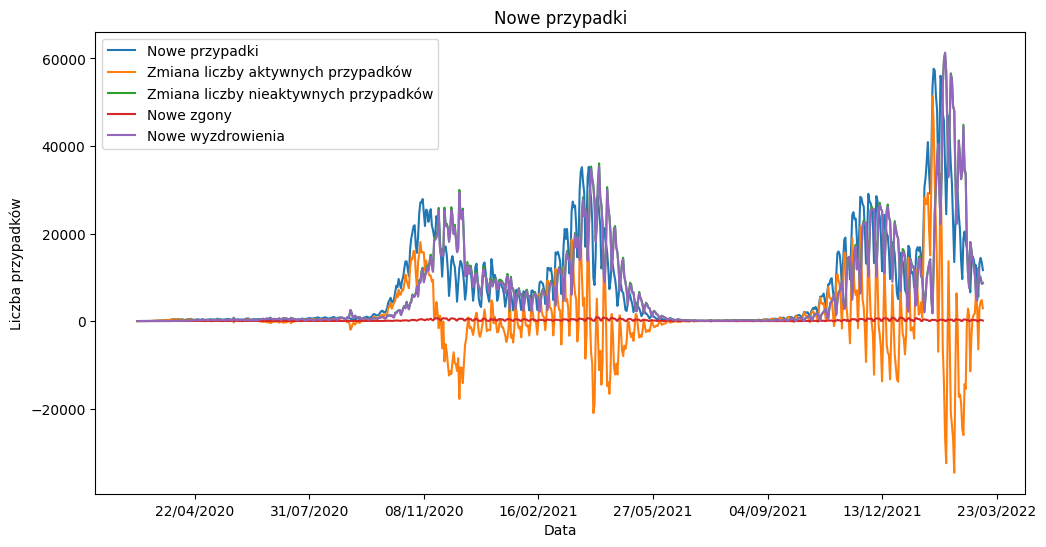

In [2]:
# Visualize the data
def visualise(df):
    plt.figure(figsize=(12, 6))
    plt.title('Nowe przypadki')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
    plt.plot(df['Data'], df['Nowe przypadki'], label='Nowe przypadki')
    plt.plot(df['Data'], df['Zmiana liczby aktywnych przypadków'], label='Zmiana liczby aktywnych przypadków')
    plt.plot(df['Data'], df['Zmiana liczby nieaktywnych przypadków'], label='Zmiana liczby nieaktywnych przypadków')
    plt.plot(df['Data'], df['Nowe zgony'], label='Nowe zgony')
    plt.plot(df['Data'], df['Nowe wyzdrowienia'], label='Nowe wyzdrowienia')
    plt.xlabel('Data')
    plt.ylabel('Liczba przypadków')
    plt.legend()
    plt.show()

visualise(df)

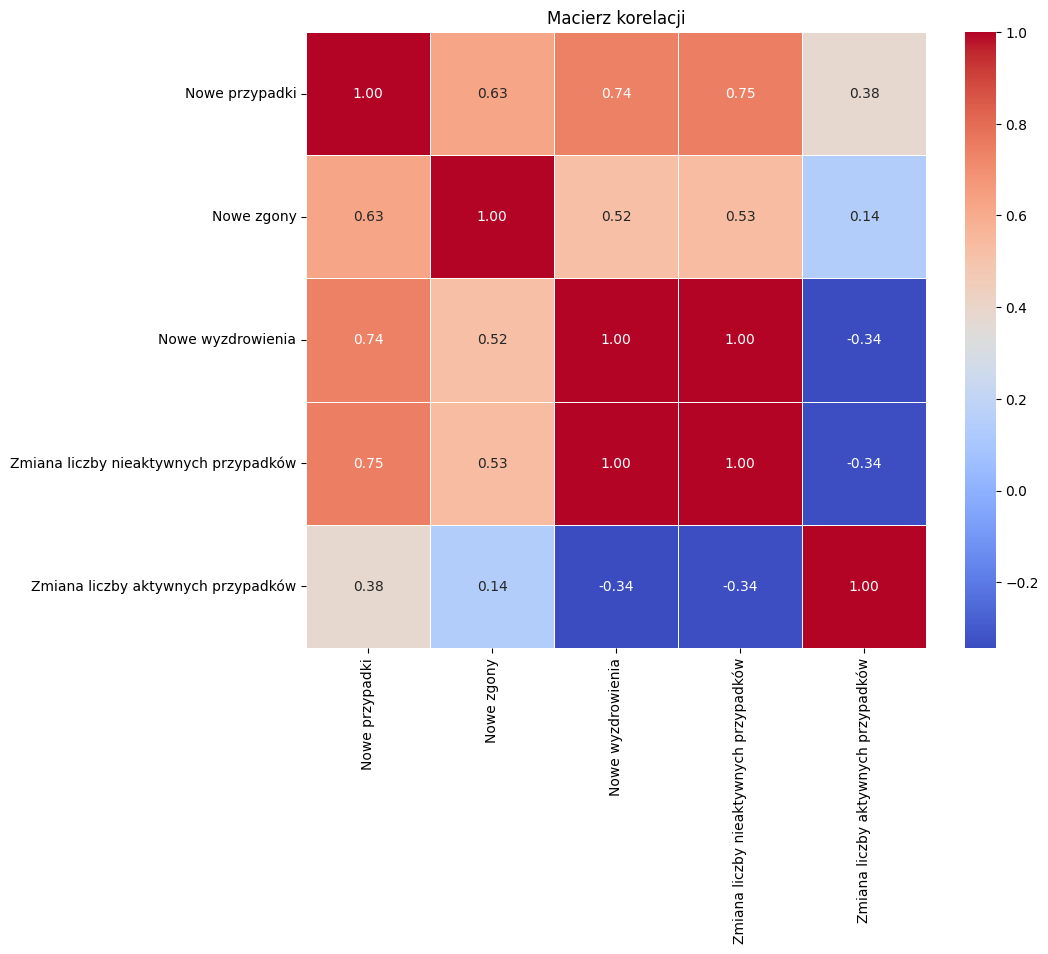

In [3]:
# Calculate the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=['Data']).corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title('Macierz korelacji')
plt.show()

In [4]:
df.tail()

,Data,Nowe przypadki,Nowe zgony,Nowe wyzdrowienia,Zmiana liczby nieaktywnych przypadków,Zmiana liczby aktywnych przypadków
734,2022-03-07,5585,6,12049,12055,-6470
735,2022-03-08,13152,217,9990,10207,2945
736,2022-03-09,14415,234,9826,10060,4355
737,2022-03-10,13438,184,8460,8644,4794
738,2022-03-11,11637,121,8599,8720,2917


In [5]:
# Scaling the data
scaler = MinMaxScaler()
df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia']] = scaler.fit_transform(df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia']])

# Split the data into training and testing sets
split_ratio = 0.8
split_idx = int(len(df) * split_ratio)
train_df = df[:split_idx]
test_df = df[split_idx:]

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # Predict only the "Nowe przypadki"
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Example sequence length
train_data = train_df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia']].values
test_data = test_df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia']].values

x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=128, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.model_type = 'Transformer'
        self.embedding = nn.Linear(num_features, d_model)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)

        self.linear = nn.Linear(d_model, 1)  # Predict only one value
        self.dropout = nn.Dropout(p=dropout)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def positional_encoding(self, seq_len, d_model):
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(1)  # Add batch dimension

    def forward(self, src, tgt):
        src = self.embedding(src)  # Apply embedding layer
        tgt = self.embedding(tgt)  # Apply embedding layer
        src = src.permute(1, 0, 2)  # Transformer expects seq_len, batch_size, num_features
        tgt = tgt.permute(1, 0, 2)

        src_pe = self.positional_encoding(src.size(0), src.size(2)).to(src.device)
        tgt_pe = self.positional_encoding(tgt.size(0), tgt.size(2)).to(tgt.device)

        src = src + src_pe
        tgt = tgt + tgt_pe

        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(tgt, memory)
        output = self.linear(output)
        return output.permute(1, 0, 2)

# Model parameters
num_features = 5
seq_length = 30  # Set the sequence length here
d_model = 64
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 128
dropout = 0.1

model = TimeSeriesTransformer(num_features, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
# Training parameters
epochs = 20
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop with test loss calculation
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for batch in train_dataloader:
        x_batch, y_batch = batch
        optimizer.zero_grad()

        # Transformer needs a target sequence as well, we'll use a shifted version of the input
        y_input = torch.zeros_like(x_batch)
        y_input[:, 1:, :] = x_batch[:, :-1, :]
        y_input[:, 0, :] = x_batch[:, 0, :]  # First element as it is

        output = model(x_batch, y_input)
        loss = criterion(output[:, -1, 0], y_batch)  # Ensure the dimensions match
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * x_batch.size(0)

    train_loss = running_train_loss / len(train_dataloader.dataset)

    # Calculate test loss
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for batch in test_dataloader:
            x_batch, y_batch = batch

            y_input = torch.zeros_like(x_batch)
            y_input[:, 1:, :] = x_batch[:, :-1, :]
            y_input[:, 0, :] = x_batch[:, 0, :]

            output = model(x_batch, y_input)
            loss = criterion(output[:, -1, 0], y_batch)  # Ensure the dimensions match

            running_test_loss += loss.item() * x_batch.size(0)

    test_loss = running_test_loss / len(test_dataloader.dataset)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/20, Train Loss: 0.1404, Test Loss: 0.3031
Epoch 2/20, Train Loss: 0.0337, Test Loss: 0.1819
Epoch 3/20, Train Loss: 0.0237, Test Loss: 0.1328
Epoch 4/20, Train Loss: 0.0194, Test Loss: 0.1103
Epoch 5/20, Train Loss: 0.0174, Test Loss: 0.0902
Epoch 6/20, Train Loss: 0.0169, Test Loss: 0.0929
Epoch 7/20, Train Loss: 0.0144, Test Loss: 0.0696
Epoch 8/20, Train Loss: 0.0118, Test Loss: 0.0594
Epoch 9/20, Train Loss: 0.0099, Test Loss: 0.0432
Epoch 10/20, Train Loss: 0.0070, Test Loss: 0.0295
Epoch 11/20, Train Loss: 0.0055, Test Loss: 0.0233
Epoch 12/20, Train Loss: 0.0043, Test Loss: 0.0252
Epoch 13/20, Train Loss: 0.0043, Test Loss: 0.0243
Epoch 14/20, Train Loss: 0.0035, Test Loss: 0.0168
Epoch 15/20, Train Loss: 0.0035, Test Loss: 0.0139
Epoch 16/20, Train Loss: 0.0041, Test Loss: 0.0165
Epoch 17/20, Train Loss: 0.0037, Test Loss: 0.0232
Epoch 18/20, Train Loss: 0.0031, Test Loss: 0.0142
Epoch 19/20, Train Loss: 0.0023, Test Loss: 0.0163
Epoch 20/20, Train Loss: 0.0024, Test Lo

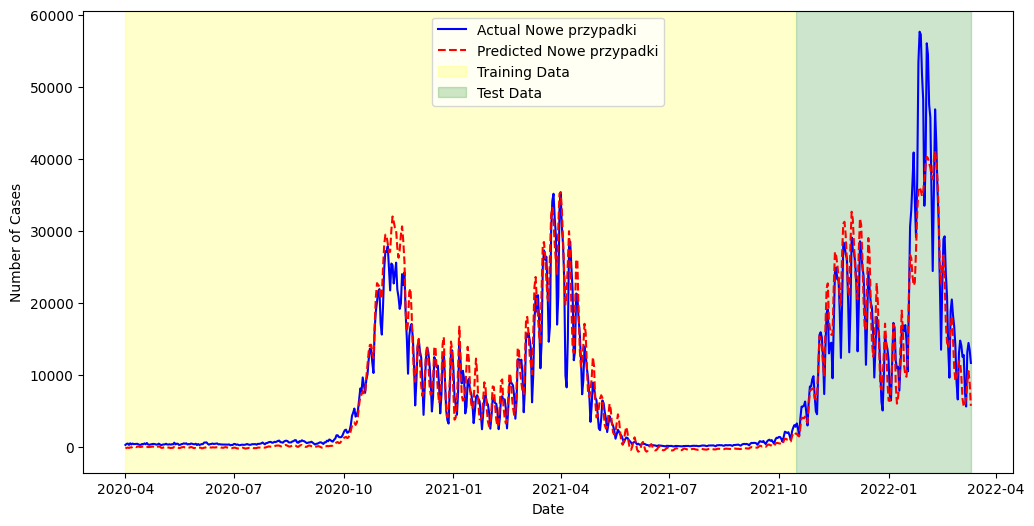

In [8]:
# Create sequences for the entire dataset for visualization purposes
def create_sequences_for_prediction(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length + 1):
        x = data[i:i+seq_length]
        xs.append(x)
    return np.array(xs)

data = df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia']].values
x_all = create_sequences_for_prediction(data, seq_length)

# Convert to PyTorch tensors
x_all = torch.tensor(x_all, dtype=torch.float32)

# Use the model to generate predictions for the entire dataset
model.eval()
with torch.no_grad():
    predictions_full = []
    for i in range(len(x_all)):
        x_input = x_all[i:i+1]  # Get one sequence at a time
        y_input = torch.zeros_like(x_input)
        y_input[:, 1:, :] = x_input[:, :-1, :]
        y_input[:, 0, :] = x_input[:, 0, :]

        output = model(x_input, y_input)
        predictions_full.append(output[:, -1, 0].numpy())  # Extract the prediction for 'Nowe przypadki'

# Convert predictions to numpy array
predictions_full = np.concatenate(predictions_full)

# Rescale the predictions back to the original scale
predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions_full.reshape(-1, 1), np.zeros((predictions_full.shape[0], 4))), axis=1))[:, 0]
y_rescaled = scaler.inverse_transform(np.concatenate((data[seq_length-1:, 0].reshape(-1, 1), np.zeros((data[seq_length-1:].shape[0], 4))), axis=1))[:, 0]

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['Data'][seq_length-1:], y_rescaled, label='Actual Nowe przypadki', color='blue')
plt.plot(df['Data'][seq_length-1:], predictions_rescaled, label='Predicted Nowe przypadki', color='red', linestyle='dashed')

# Mark the training and test data range
train_range = range(seq_length-1, split_idx)
test_range = range(split_idx, len(df))

plt.axvspan(df['Data'].iloc[train_range.start], df['Data'].iloc[train_range.stop-1], alpha=0.2, color='yellow', label='Training Data')
plt.axvspan(df['Data'].iloc[test_range.start], df['Data'].iloc[test_range.stop-1], alpha=0.2, color='green', label='Test Data')

plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()